<a href="https://colab.research.google.com/github/UlkuTuncerKucuktas/Covid19-basicCNNclassifier/blob/main/Covid_19_basic_cnn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/archive (1).zip"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: che

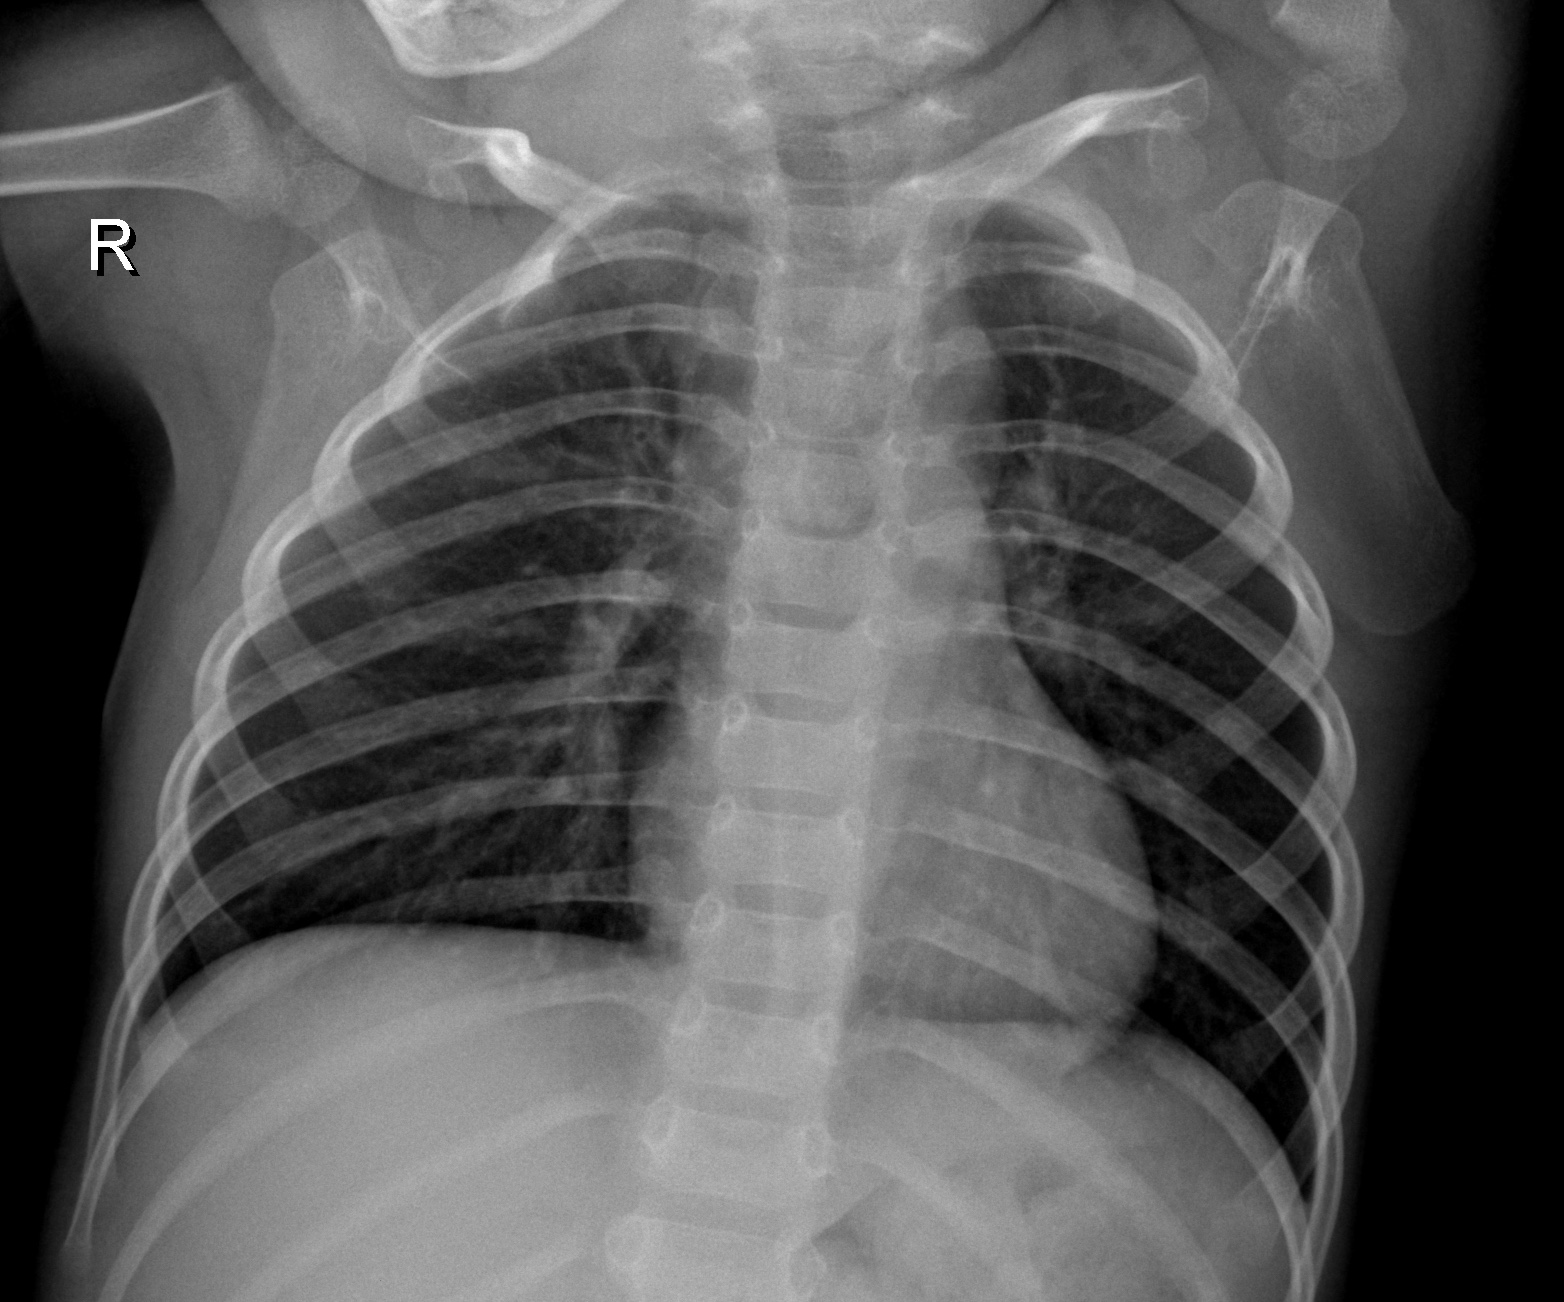

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread("chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg")

cv2_imshow(img)

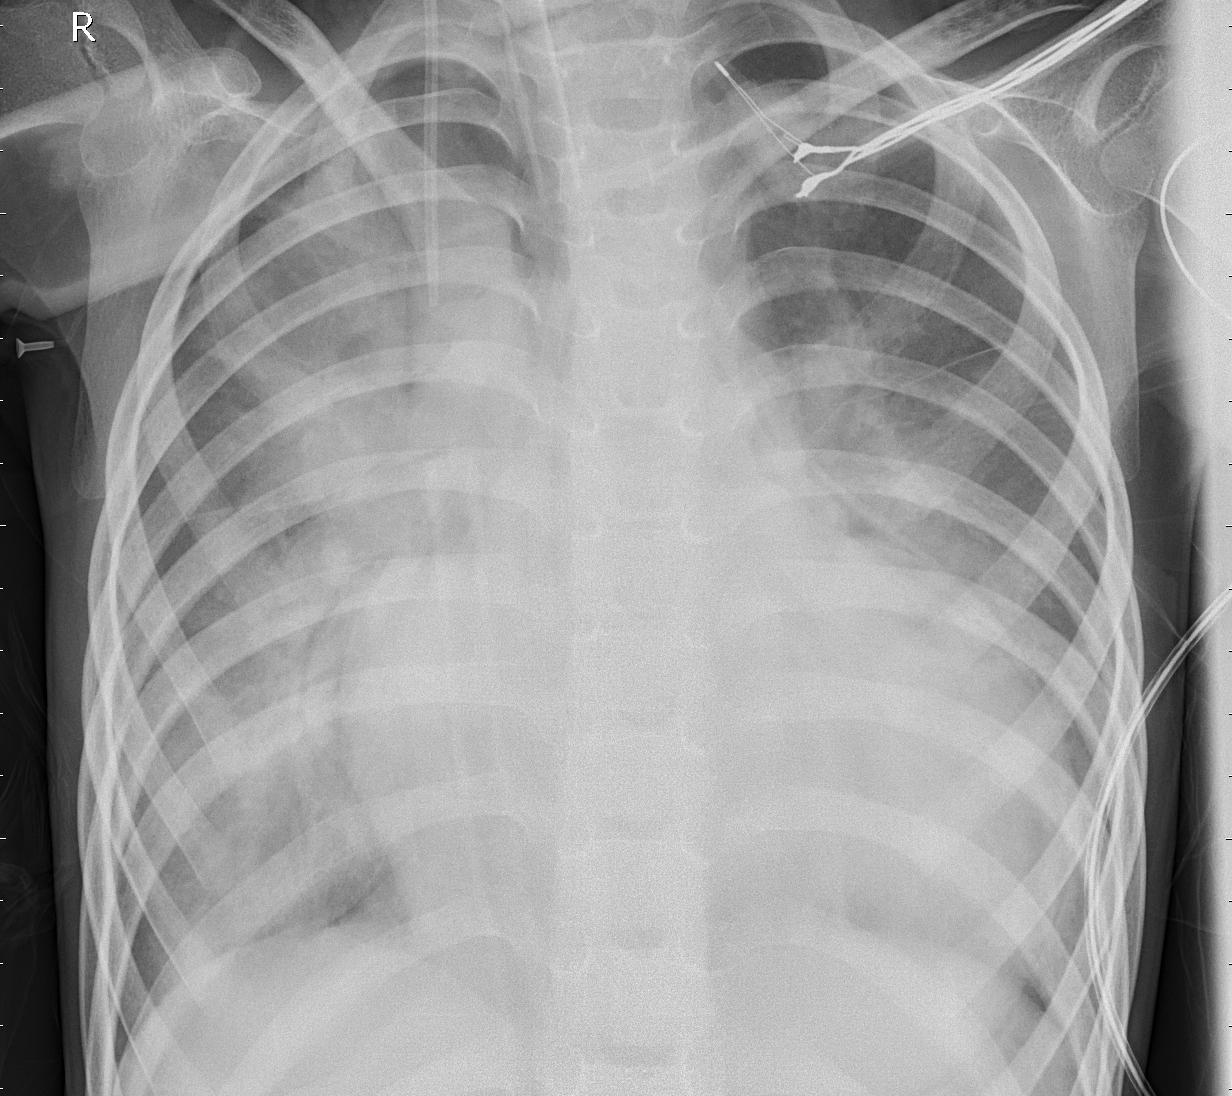

In [ ]:
img = cv2.imread("chest_xray/train/PNEUMONIA/person998_bacteria_2928.jpeg")

cv2_imshow(img)

In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
import numpy as np
import cv2
def toGrayScale(img):
  img = np.array(img) 
  if(len(img.shape) == 3):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  
  return img


In [ ]:
from torchvision import datasets, transforms as T

transformfunc = T.Compose([toGrayScale, T.ToTensor(),T.Resize(256), T.CenterCrop(224)])

In [ ]:
import torch
import torchvision.datasets as datasets

train_set = datasets.ImageFolder("/content/chest_xray/train",transform=transformfunc)
val_set = datasets.ImageFolder("/content/chest_xray/val",transform=transformfunc)

In [ ]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=train_set,batch_size=32,shuffle=True)
valloader = DataLoader(dataset=val_set,batch_size=1,shuffle=False)

In [ ]:
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',[0,1],train_set.targets )
class_weights

array([1.9448173 , 0.67303226])

In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /content/chest_xray/train
    StandardTransform
Transform: Compose(
               <function toRGB at 0x7f3c3efa10e0>
               ToTensor()
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
           )

In [ ]:
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d,Dropout,Sigmoid,BatchNorm2d

class Net(nn.Module):
  def __init__(self):
     super(Net, self).__init__()
     self.cnn_layers = Sequential(
     Conv2d(1,32, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(32),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(32,64, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(64),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(64,128, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(128),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(128,256, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(256),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2)
     )
     self.linear_layers = Sequential( 
        Linear(50176,128),
        Linear(128,2)
        )
     #Defining the forward pass
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)

    return x

model = Net()

In [ ]:
from sklearn.metrics import f1_score

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights))

optimizer = torch.optim.Adam(model.parameters())


def train(model,criterion,train_loader,optimizer,epochs = 10):
  train_loss = []
  for epoch in range(epochs):
    running_loss = 0.0
    for i,(x,y) in enumerate(train_loader):
      x,y = x.to(device),y.to(device) # Modele girecek tensorları cudaya gönder
      optimizer.zero_grad()
      z = model(x)
      loss = criterion(z,y)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 52 == 51 :
        preds = []
        actuals = []
        for x,y in valloader:
          x,y = x.to(device),y.to(device).to(torch.float32)
          z = model(x)
          label = torch.max(z,-1).indices.item()
          preds.append(label)
          actuals.append(y.item())
        score = f1_score(actuals,preds, average='macro')
        print("F1 score :",score)
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 20))



train(model,criterion,trainloader,optimizer,15)

F1 score : 0.746031746031746
[1,    52] loss: 13.787
F1 score : 0.746031746031746
[1,   104] loss: 16.165
F1 score : 0.4589371980676329
[1,   156] loss: 17.069
F1 score : 0.8117647058823529
[2,    52] loss: 0.958
F1 score : 0.8117647058823529
[2,   104] loss: 1.561
F1 score : 0.6761133603238867
[2,   156] loss: 1.912
F1 score : 0.746031746031746
[3,    52] loss: 0.239
F1 score : 0.746031746031746
[3,   104] loss: 0.409
F1 score : 0.746031746031746
[3,   156] loss: 0.580
F1 score : 0.746031746031746
[4,    52] loss: 0.164
F1 score : 0.6862745098039216
[4,   104] loss: 0.337
F1 score : 0.7333333333333334
[4,   156] loss: 0.511


KeyboardInterrupt: ignored